In [93]:
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


In [94]:
# """ import all ETHUSDT OHLC data from Binance """
coin='ETH/USDT'
timeframe='1d'
exchange=ccxt.binance()
start_date=0
# start_date = int(datetime.datetime(2017, 1, 1, 1, 1).timestamp() * 1000)

data=pd.DataFrame(columns=['date', 'open', 'high', 'low', 'close', 'volume'])

while True:
    response=exchange.fetch_ohlcv(coin, timeframe, since=start_date, limit=1000)
    df=pd.DataFrame(response, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    updateData=pd.merge(data, df, how='outer')
    if len(data)!=len(updateData):
        data=updateData.copy()
        start_date=data['date'].iloc[-1]
    else:
        break
    
data.drop_duplicates(inplace=True)
data.date=pd.to_datetime(data['date'], unit='ms', utc=True, yearfirst=True)
print(data.head(10))

                       date    open    high     low   close      volume
0 2017-08-17 00:00:00+00:00  301.13  312.18  298.00  302.00  7030.71034
1 2017-08-18 00:00:00+00:00  302.00  311.79  283.94  293.96  9537.84646
2 2017-08-19 00:00:00+00:00  293.31  299.90  278.00  290.91  2146.19773
3 2017-08-20 00:00:00+00:00  289.41  300.53  282.85  299.10  2510.13871
4 2017-08-21 00:00:00+00:00  299.10  346.52  294.60  323.29  5219.44542
5 2017-08-22 00:00:00+00:00  321.04  330.41  144.21  309.80  7956.35088
6 2017-08-23 00:00:00+00:00  312.25  324.99  309.41  315.74  8665.72569
7 2017-08-24 00:00:00+00:00  315.74  328.04  314.01  323.42  6753.27192
8 2017-08-25 00:00:00+00:00  323.42  338.28  323.42  327.24  7125.96962
9 2017-08-26 00:00:00+00:00  327.24  335.44  323.41  330.79  4877.68521


In [95]:
# Calculate drawdown
HighestHigh = [data['high'].iloc[0]]
for i in range(1,len(data)):
    if data['high'].iloc[i] >= HighestHigh[-1]:
        HighestHigh.append(data['high'].iloc[i])
    else:
        HighestHigh.append(HighestHigh[-1])
        
data['HighestHigh'] = HighestHigh
data['DrawDown'] = data.apply(lambda row: 0 if row['high']==row['HighestHigh'] else (row['low']-row['HighestHigh'])*100/row['HighestHigh'], axis=1)



In [96]:
# Maximum Drawdown (MDD) 
print("Maximum Drawdown (MDD): {0} %".format(data.loc[data['DrawDown'] == min(data['DrawDown']) ,"DrawDown"].values[0].round(2)))  

Maximum Drawdown (MDD): -94.32 %


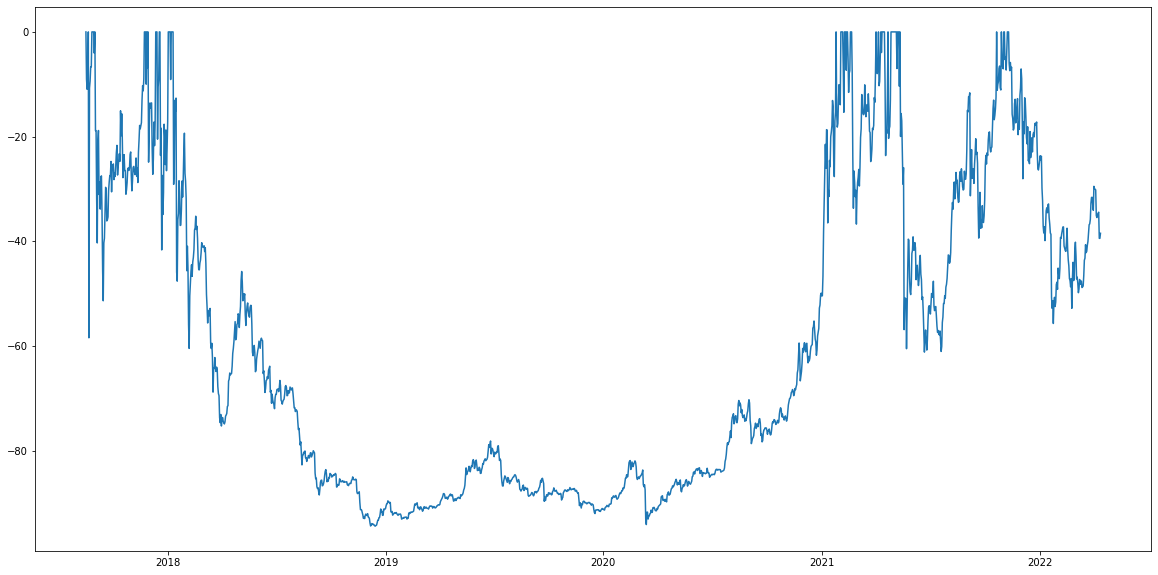

In [97]:
# plot drawdown
plt.figure(figsize=(20,10))
plt.plot(data['date'], data['DrawDown'])

In [98]:
# add important variables

for i in range(1,51):
    data['pctchange{0}'.format(i)]=data['close'].pct_change(i)

for i in range(1,51):
    data['pctchange1_{0}'.format(i)] = data['pctchange1'].shift(i)
    data['DrawDown{0}'.format(i)] = data['DrawDown'].shift(i)
print(len(data))

1702


In [99]:
# print(data['date'].dtypes)
# data['date2']=data['date'].isocalendar

data['year']=data['date'].dt.year
data['month']=data['date'].dt.month
data['day']=data['date'].dt.day
data['dayofyear']=data['date'].dt.dayofyear

data.dropna(inplace=True)
print(data.shape)


(1651, 162)


In [103]:
# Definig target column 
# The trading situation can earn more than 1% profit
# data['target']=data['pctchange1'].apply(lambda x : 'buy' if x>0.01 else 'sell')
data['target']=data['pctchange1'].apply(lambda x : 1 if x>0.01 else 0)


In [104]:
# we subset our data frame to 
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(['date','pctchange1','target'])], data['target'], test_size=0.33, random_state=42)

In [111]:
# xg_reg = xgb.XGBRegressor(objective = "reg:linear",
#                           colsample_bytree=1,
#                           learning_rate = 0.1,
#                           gamma=3,
#                           max_depth = 10,
#                           alpha=20,
#                           n_estimators =1000,
#                           min_child_weight=7,
#                           reg_alpha=1e-05,
#                           reg_lambda=1e-05,
#                           subsample=0.95)

xg_reg = xgb.XGBClassifier(num_class=1,
                            # learning_rate=0.1,
                            # num_iterations=1000,
                            # max_depth=10,
                            # feature_fraction=0.7, 
                            # scale_pos_weight=1.5,
                            # boosting='gbdt',
                            # metric='multiclass',
                            eval_metric='mlogloss',
                            use_label_encoder=False)


In [112]:
xg_reg.fit( X_train, y_train )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_class=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

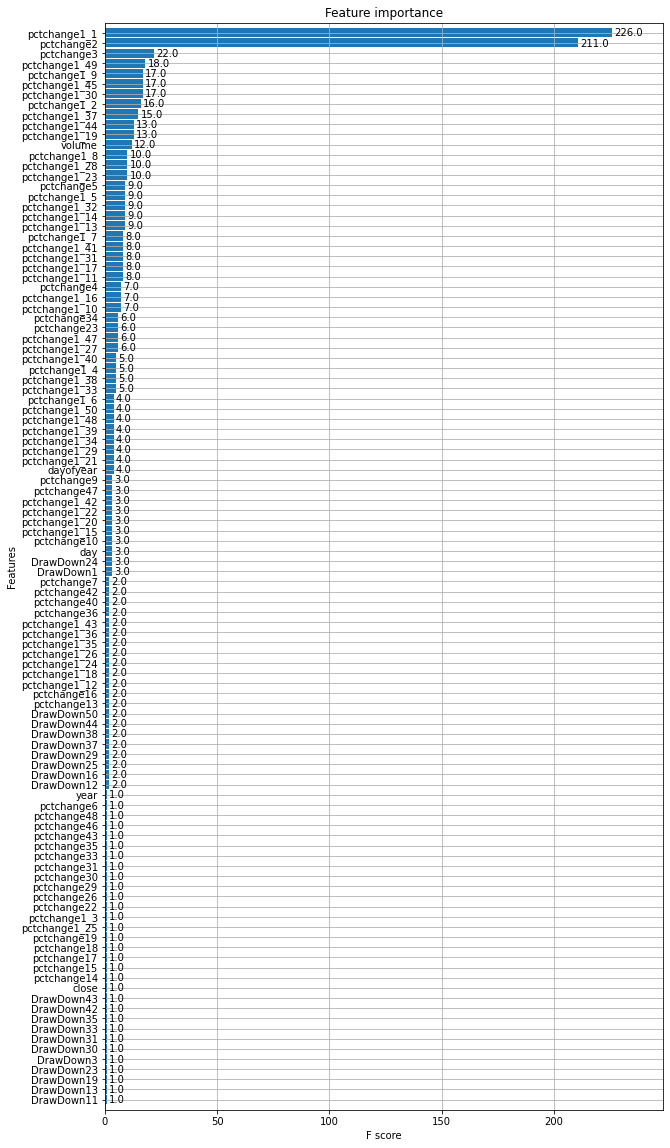

In [113]:
ax= plot_importance( xg_reg , height=0.9)
fig = ax.figure
fig.set_size_inches(10, 20)


In [114]:
accuracies = cross_val_score(estimator=xg_reg, X=X_train, y=y_train, cv=10, n_jobs=1)

In [115]:
print(accuracies.mean())
print(accuracies.std())
print(accuracies)

0.9412776412776414
0.01806642295627307
[0.91891892 0.95495495 0.93693694 0.92792793 0.93693694 0.91891892
 0.95454545 0.92727273 0.96363636 0.97272727]


In [ ]:
y_pred = xg_reg.predict(X_test)
cm=confusion_matrix(y_test, y_pred)

In [ ]:
result = pd.DataFrame(columns=['pred','real'])
result['pred']=y_pred
result['real']=list(y_test)

In [ ]:
# DecisionTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X_train, y_train, cv=10)